In [154]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit


def autocorr(x):
    length = len(x)
    mean = x.mean()
    squared = (x ** 2).mean()
    corr = np.zeros(int(length / 2))
    corr[0] = 1
    for k in range(1, int(length / 2)):
        mean_k = (x[:-k] * x[k:]).mean()
        corr[k] = (mean_k - mean ** 2) / (squared - mean ** 2)
    return corr

## Energy and magnetization termalization

#### Termalizacion en funcion de J

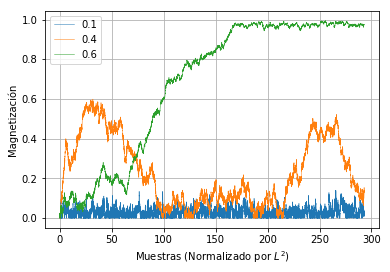

In [10]:
length = 300000

x = np.arange(length) / 32 / 32
for j in ['0.1', '0.4', '0.6']:
    
    df = pd.read_csv(f'../valores/terma_{j}.dat')
    m = np.zeros(length)
    e = np.zeros(length)
    
    ids = df.id.unique()
    for i in ids:
        m += abs(df.query(f'id == {i}').m.values[0:length])
        e += df.query(f'id == {i}').e.values[0:length]
        
    m = m / len(ids)
#     e = e / len(ids)
    plt.plot(x, m, label=j, linewidth=.5)
#     plt.plot(e, label=j)

plt.grid()
plt.xlabel("Muestras (Normalizado por $L^2$)")
plt.ylabel("Magnetización")
plt.legend()
plt.savefig('../ising/images/termalizacion.png')
plt.show()

### Correlacion

Para samples despues de la termalizacion, calcular la autocorrelacion.

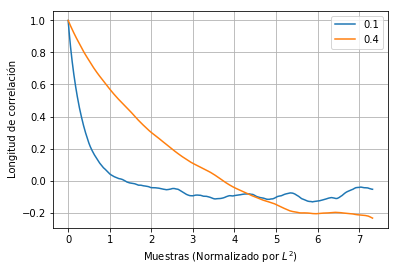

In [16]:
termalizacion = 0
length = 15000

x = np.arange((length - termalizacion) // 2) / 32 / 32
for j in ['0.1', '0.4']:
    
    df = pd.read_csv(f'../valores/terma_{j}.dat')
    corr = np.zeros((length - termalizacion) // 2)
    
    ids = df.id.unique()
    for i in ids:
        corr += autocorr(abs(df.query(f'id == {i}').m.values[termalizacion:length]))
    corr = corr / len(ids)

    plt.plot(x, corr, label=j)

plt.grid()
plt.xlabel("Muestras (Normalizado por $L^2$)")
plt.ylabel("Longitud de correlación")
plt.legend()
plt.savefig('../ising/images/correlation.png')
plt.show()

# Ising

In [291]:
df = pd.read_csv(f'../valores/ising.dat', names=['j', 'h', 'm', 'h2', 'm2'])
df.m = abs(df.m)
grouped = df.groupby('j', as_index=False).agg('mean')
grouped['chi'] = grouped.m2 - grouped.m ** 2
grouped['c'] = grouped.h2 - grouped.h ** 2

##### Magnetization

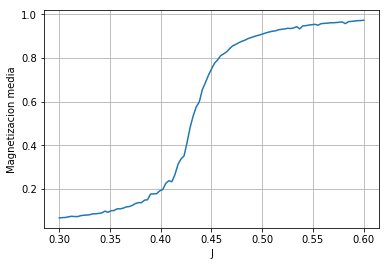

In [292]:
plt.plot(grouped.j, grouped.m)
plt.grid()
plt.xlabel('J')
plt.ylabel('Magnetizacion media')
plt.savefig('../ising/images/magnetization_vs_j.png')
plt.show()

##### $\beta$ adjustment

In [293]:
df = pd.read_csv(f'../valores/beta.dat', names=['j', 'h', 'm', 'h2', 'm2'])
df.m = abs(df.m)
grouped = df.groupby('j', as_index=False).agg('mean')

\beta = (0.108 \pm 0.002)


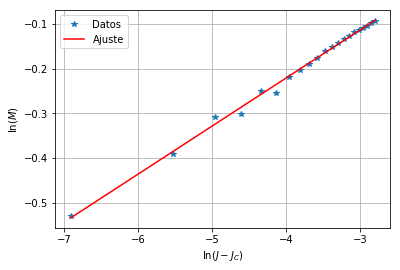

In [294]:
adjustment = grouped

x = np.log(adjustment.j - 0.439)
y = np.log(adjustment.m)
coeffs, cov = np.polyfit(x, y, 1, cov=True)

print(r'\beta = ({:.3f} \pm {:.3f})'.format(coeffs[0], np.sqrt(cov[0,0])))

plt.plot(x, y, '*', label='Datos')
plt.plot(x, coeffs[0] * x + coeffs[1], 'r', label='Ajuste')
plt.grid()
plt.legend()
plt.xlabel('$\ln(J - J_C)$')
plt.ylabel('$\ln(M)$')
plt.savefig('../ising/images/ajuste_beta.png')
plt.show()

##### Chi

In [295]:
df = pd.read_csv(f'../valores/ising.dat', names=['j', 'h', 'm', 'h2', 'm2'])
df.m = abs(df.m)
grouped = df.groupby('j', as_index=False).agg('mean')
grouped = grouped.query('j < 0.55')
grouped['chi'] = grouped.m2 - grouped.m ** 2
grouped['c'] = grouped.h2 - grouped.h ** 2

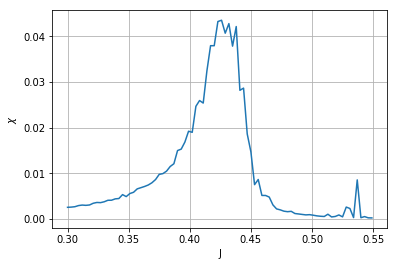

In [296]:
plt.plot(grouped.j, grouped.chi)
plt.grid()
plt.xlabel('J')
plt.ylabel('$\chi$')
plt.savefig('../ising/images/chi_vs_j.png')
plt.show()

\gamma = (1.70 \pm 0.10)
J_C = (0.421 \pm 0.001)


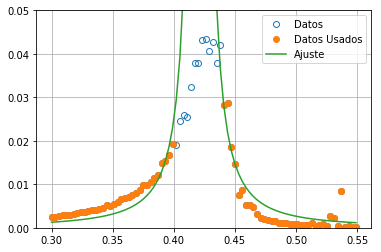

In [297]:
def gamma(x, gamma, j_c, a):
    return a * abs(x - j_c) ** (-gamma)


x, y = grouped.j, grouped.chi

x_fit = x[x.apply(lambda x: not 0.40 < x < 0.44)]
y_fit = y[x.apply(lambda x: not 0.40 < x < 0.44)]

popt, pcov = curve_fit(gamma, x_fit, y_fit, p0=(7 / 4, 0.44, 200))

print('\gamma = ({:.2f} \pm {:.2f})'.format(popt[0], np.sqrt(pcov[0, 0])))
print('J_C = ({:.3f} \pm {:.3f})'.format(popt[1], np.sqrt(pcov[1, 1])))

plt.plot(x, y, 'o', label='Datos', fillstyle='none')
plt.plot(x_fit, y_fit, 'o', label='Datos Usados')
plt.plot(x, gamma(x, *popt), label='Ajuste')
plt.ylim(0, 0.05)
plt.legend()
plt.grid()
plt.savefig('../ising/images/ajuste_gamma.png')
plt.show()    

##### C

In [222]:
df = pd.read_csv(f'../valores/ising.dat', names=['j', 'h', 'm', 'h2', 'm2'])
df.m = abs(df.m)
grouped = df.groupby('j', as_index=False).agg('mean')
grouped = grouped.query('j < 0.55')
grouped['chi'] = grouped.m2 - grouped.m ** 2
grouped['c'] = grouped.h2 - grouped.h ** 2

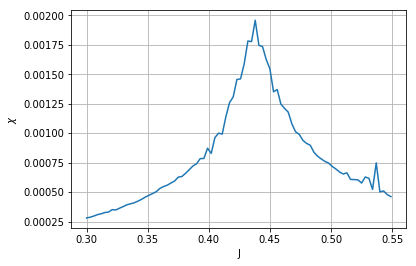

In [223]:
plt.plot(grouped.j, grouped.c)
plt.grid()
plt.xlabel('J')
plt.ylabel('$\chi$')
plt.savefig('../ising/images/c_vs_j.png')
plt.show()

\alpha = (-0.0017 \pm 0.0002)


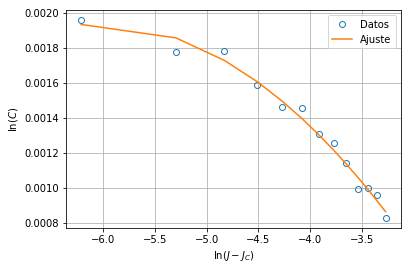

In [226]:
x_fit = grouped.j[grouped.j.apply(lambda x: 0.40 < x < 0.44)]
y_fit = grouped.c[grouped.j.apply(lambda x: 0.40 < x < 0.44)]

x_fit = np.log(abs(x_fit - 0.44))

coeffs, cov = np.polyfit(x_fit, y_fit, 2, cov=True)

print(r'\alpha = ({:.4f} \pm {:.4f})'.format(coeffs[1], np.sqrt(cov[1,1])))

plt.plot(x_fit, y_fit, 'o', label='Datos', fillstyle='none')
plt.plot(x_fit, coeffs[0] * x_fit ** 2 + coeffs[1] * x_fit + coeffs[2], label='Ajuste')
plt.xlabel('$\ln(J - J_C)$')
plt.ylabel('$\ln(C)$')
plt.legend()
plt.grid()
plt.savefig('../ising/images/ajuste_alpha.png')
plt.show()

### Red Finita

In [269]:
df = pd.read_csv(f'../valores/red.dat', names=['l', 'j', 'h', 'm', 'h2', 'm2'])
df.m = abs(df.m)
df = df.query('l != 64')
df = df.query('l != 4')
grouped = df.groupby(['j', 'l'], as_index=False).agg('mean')
grouped['chi'] = grouped.m2 - grouped.m ** 2
grouped['c'] = grouped.h2 - grouped.h ** 2

##### Magnetization vs L

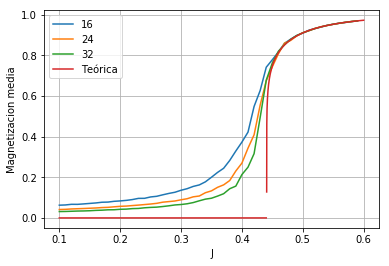

In [281]:
def teorica(x):
    if x < 0.44:
        return 0
    else:
        return (1 - np.sinh(2 * x) ** (-4)) ** (1 / 8)


for l in sorted(grouped.l.unique()):
    temp = grouped.query(f'l == {l}')
    plt.plot(temp.j, temp.m, label=l)
plt.plot(np.arange(0.1, 0.6, 0.0000001), pd.Series(np.arange(0.1, 0.6, 0.0000001)).apply(teorica), label='Teórica')
plt.grid()
plt.xlabel('J')
plt.ylabel('Magnetizacion media')
plt.legend()
plt.savefig('../ising/images/magnetization_vs_l.png')
plt.show()

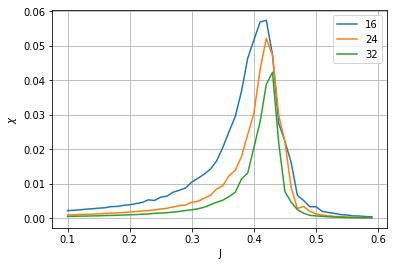

In [282]:
for l in sorted(grouped.l.unique()):
    temp = grouped.query(f'l == {l}')
    plt.plot(temp.j, temp.chi, label=l)
plt.grid()
plt.xlabel('J')
plt.ylabel('$\chi$')
plt.legend()
plt.savefig('../ising/images/chi_vs_l.png')
plt.show()

\gamma = (1.06 \pm 0.09)
J_C = (0.407 \pm 0.002)
\gamma = (1.50 \pm 0.10)
J_C = (0.416 \pm 0.001)
\gamma = (1.69 \pm 0.12)
J_C = (0.417 \pm 0.001)


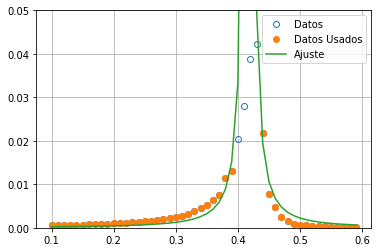

In [264]:
def gamma(x, gamma, j_c, a):
    return a * abs(x - j_c) ** (-gamma)

for l in sorted(grouped.l.unique()):
    temp = grouped.query(f'l == {l}')

    x, y = temp.j, temp.chi

    x_fit = x[x.apply(lambda x: not 0.39 < x < 0.44)]
    y_fit = y[x.apply(lambda x: not 0.39 < x < 0.44)]

    popt, pcov = curve_fit(gamma, x_fit, y_fit, p0=(7 / 4, 0.41, 100))

    print('\gamma = ({:.2f} \pm {:.2f})'.format(popt[0], np.sqrt(pcov[0, 0])))
    print('J_C = ({:.3f} \pm {:.3f})'.format(popt[1], np.sqrt(pcov[1, 1])))

## Antiferro

In [299]:
df = pd.read_csv(f'../valores/antiferro.dat', names=['l', 'j', 'h', 'm', 'h2', 'm2'])
df.m = abs(df.m)
grouped = df.groupby('j', as_index=False).agg('mean')
grouped['chi'] = grouped.m2 - grouped.m ** 2
grouped['c'] = grouped.h2 - grouped.h ** 2

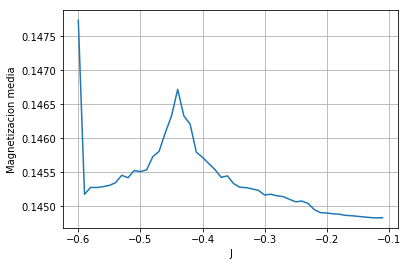

In [308]:
plt.plot(grouped.j, grouped.c)
plt.grid()
plt.xlabel('J')
plt.ylabel('Magnetizacion media')
# plt.savefig('../ising/images/antiferro.png')
plt.show()